In [43]:
import os
import math
import pandas as pd
import torch
import torch.nn.functional as F
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset,DataLoader,random_split
from torch.optim.lr_scheduler import _LRScheduler
from torch.nn import Transformer
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import wandb
import warnings
warnings.filterwarnings('ignore')
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

# Validation Set 구성

In [ ]:
def valset_check(df):
    length = len(df)
    idx_list = []
    for w in range(0,length-120):
        idx = df.iloc[w:w+120].index
        flag = True
        
        for i in range(1,len(idx)):
            if idx[i-1]+1 != idx[i]:
                flag=False
                break
        
        if flag:
            idx_list.append(idx)
        
    return idx_list

val_set_dict = dict()

for loca in tqdm(data_dict.keys()):
    val_set_dict[loca] = valset_check(data_dict[loca])

# EDA

## 공주지역

### PM 분포

PM_왜도: 2.29719388281209
PM_첨도: 9.973496844637072


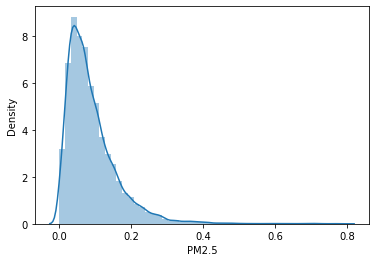

In [2]:
df_공주 = pd.read_csv('/opt/ml/data/TRAIN/공주.csv')
df_aws_공주 = pd.read_csv('/opt/ml/data/TRAIN_AWS/공주.csv')

sns.distplot(df_공주['PM2.5'])
print('PM_왜도: {}'.format(df_공주['PM2.5'].skew()))
print('PM_첨도: {}'.format(df_공주['PM2.5'].kurtosis()))

### 기온 분포

기온_왜도: -0.18290468803721474
기온_첨도: -0.8987470552057557


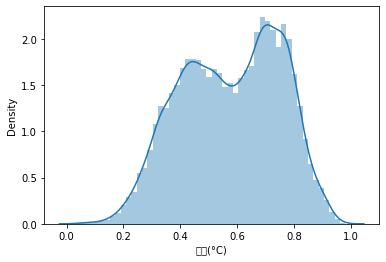

In [3]:
sns.distplot(df_aws_공주['기온(°C)'])
print('기온_왜도: {}'.format(df_aws_공주['기온(°C)'].skew()))
print('기온_첨도: {}'.format(df_aws_공주['기온(°C)'].kurtosis()))

### 풍향 분포

풍향_왜도: 0.37363438626135553
풍향_첨도: -1.4711895360523195


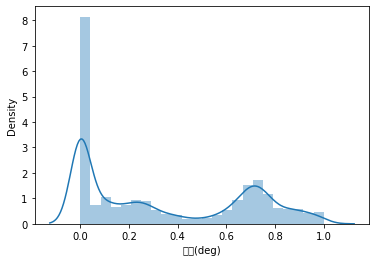

In [4]:
sns.distplot(df_aws_공주['풍향(deg)'])
print('풍향_왜도: {}'.format(df_aws_공주['풍향(deg)'].skew()))
print('풍향_첨도: {}'.format(df_aws_공주['풍향(deg)'].kurtosis()))

### 풍속 분포

풍속_왜도: 1.2281327894225371
풍속_첨도: 1.848898051568542


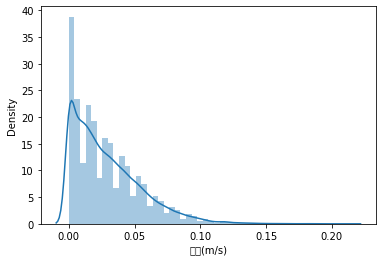

In [5]:
sns.distplot(df_aws_공주['풍속(m/s)'])
print('풍속_왜도: {}'.format(df_aws_공주['풍속(m/s)'].skew()))
print('풍속_첨도: {}'.format(df_aws_공주['풍속(m/s)'].kurtosis()))

### 강수량 분포

강수량_왜도: 17.53746250951375
강수량_첨도: 552.0305520014417


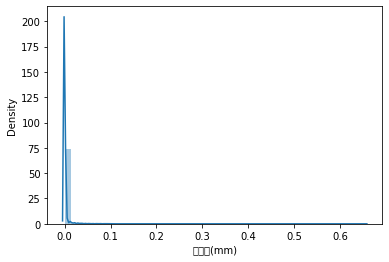

In [6]:
sns.distplot(df_aws_공주['강수량(mm)'])
print('강수량_왜도: {}'.format(df_aws_공주['강수량(mm)'].skew()))
print('강수량_첨도: {}'.format(df_aws_공주['강수량(mm)'].kurtosis()))

### 습도 분포

습도_왜도: -0.5556925897971579
습도_첨도: -0.7496544533276639


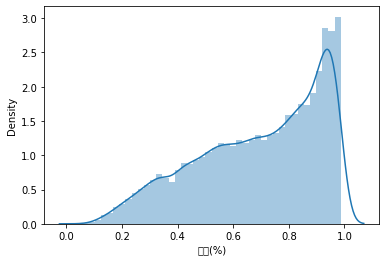

In [7]:
sns.distplot(df_aws_공주['습도(%)'])
print('습도_왜도: {}'.format(df_aws_공주['습도(%)'].skew()))
print('습도_첨도: {}'.format(df_aws_공주['습도(%)'].kurtosis()))

### PM 추세선

In [ ]:
sns.lineplot(df_공주['PM2.5'])

* 연도별 패턴과 계절성이 보임

### PM boxplot

In [ ]:
sns.boxplot(data = df_공주, y=df_공주['PM2.5'] )

* 이상치가 많음 -> 확인 필요

In [8]:
#통계 수치 확인
df_cat = pd.concat([df_공주,df_aws_공주.iloc[:,3:]], axis=1)
df_cat.describe()

,연도,PM2.5,기온(°C),풍향(deg),풍속(m/s),강수량(mm),습도(%)
count,35064.000000,34294.000000,34380.000000,34380.000000,34380.000000,34380.000000,34380.000000
mean,1.501027,0.089519,0.578108,0.346713,0.028784,0.001627,0.694966
std,1.118356,0.072571,0.175015,0.337584,0.025935,0.011652,0.222819
min,0.000000,0.000000,0.039494,0.000000,0.000000,0.000000,0.058000
25%,1.000000,0.040000,0.436019,0.000000,0.007673,0.000000,0.529000
50%,2.000000,0.072000,0.589258,0.236528,0.023018,0.000000,0.737000
75%,3.000000,0.116000,0.723539,0.698333,0.043478,0.000000,0.894000
max,3.000000,0.792000,0.981043,1.000000,0.212276,0.653409,0.987000


In [ ]:
df_cat.corr()

In [9]:
#결측치 파악
df_cat.isna().sum()

연도           0
일시           0
측정소          0
PM2.5      770
기온(°C)     684
풍향(deg)    684
풍속(m/s)    684
강수량(mm)    684
습도(%)      684
dtype: int64

## 통합 데이터 구축

In [10]:
#aws-pm data 매칭 -> 거리 기준

meta_df_pm = pd.read_csv('/opt/ml/data/META/pmmap.csv')
pm_loca_data = meta_df_pm.iloc[:,:3].to_numpy()

meta_df_aws = pd.read_csv('/opt/ml/data/META/awsmap.csv')
aws_loca_data = meta_df_aws.iloc[:,:3].to_numpy()

aws_match_list = []

for pm in pm_loca_data:
    pm_loca, pm_la, pm_lo = pm
    
    min_norm = float('inf')
    min_loca = ''
    for aws in aws_loca_data:
        aws_loca, aws_la, aws_lo = aws
        val = np.array([pm_la - aws_la, pm_lo - aws_lo])
        no = np.linalg.norm(val)
        if min_norm > no:
            min_norm = no
            min_loca = aws_loca
    
    aws_match_list.append((pm_loca, min_loca))

#pm-aws matching dict형태
aws_match_dict = dict()
for pm, aws in aws_match_list:
    aws_match_dict[pm] = aws

data_dict = {}    
train_path = '/opt/ml/data/TRAIN'
trainaws_path = '/opt/ml/data/TRAIN_AWS/'

def merge_df(pm_loca, aws_loca):
    df_pm_loca = pd.read_csv(os.path.join(train_path, pm_loca+'.csv'))
    df_aws_loca = pd.read_csv(os.path.join(trainaws_path, aws_loca+'.csv')).iloc[:,3:]
    df = pd.concat([df_pm_loca,df_aws_loca],axis=1).iloc[:,3:]
    return df
    
    

for loca in aws_match_list:
    pm_loca, aws_loca = loca
    data_dict[pm_loca] = merge_df(pm_loca, aws_loca)

In [11]:
df_total = pd.concat(list(data_dict.values()),axis=0)
df_total.describe()

,PM2.5,기온(°C),풍향(deg),풍속(m/s),강수량(mm),습도(%)
count,580546.000000,585790.000000,585790.000000,585790.000000,585790.000000,585790.000000
mean,0.085153,0.581792,0.418020,0.040295,0.001546,0.706114
std,0.071679,0.165542,0.342206,0.035796,0.012335,0.206325
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.036000,0.450237,0.036111,0.012788,0.000000,0.559000
50%,0.068000,0.590837,0.408333,0.033248,0.000000,0.729000
75%,0.112000,0.718799,0.728333,0.058824,0.000000,0.890000
max,1.000000,0.998420,1.000000,0.434783,0.897727,0.988000


In [12]:
#상관관계 분석
df_total.corr()

,PM2.5,기온(°C),풍향(deg),풍속(m/s),강수량(mm),습도(%)
PM2.5,1.000000,-0.247859,-0.037916,-0.157025,-0.078880,0.040146
기온(°C),-0.247859,1.000000,0.035149,0.086485,0.064555,0.032808
풍향(deg),-0.037916,0.035149,1.000000,0.403602,-0.018477,-0.288281
풍속(m/s),-0.157025,0.086485,0.403602,1.000000,0.047413,-0.304950
강수량(mm),-0.078880,0.064555,-0.018477,0.047413,1.000000,0.144939
습도(%),0.040146,0.032808,-0.288281,-0.304950,0.144939,1.000000


In [13]:
#전체 결측치 파악
df_total.isna().sum()

PM2.5      15542
기온(°C)     10298
풍향(deg)    10298
풍속(m/s)    10298
강수량(mm)    10298
습도(%)      10298
dtype: int64

# 이상치 파악

In [ ]:
#아름동 Feature 확인
fig, axes = plt.subplots(nrows=1, ncols=6, figsize = (16,5))
sns.boxplot(df_total.iloc[:35064,0], ax=axes[0])
sns.boxplot(df_total.iloc[:35064,1], ax=axes[1])
sns.boxplot(df_total.iloc[:35064,2], ax=axes[2])
sns.boxplot(df_total.iloc[:35064,3], ax=axes[3])
sns.boxplot(df_total.iloc[:35064,4], ax=axes[4])
sns.boxplot(df_total.iloc[:35064,5], ax=axes[5])

axes[0].set_title('PM2.5')
axes[1].set_title('Tmp')
axes[2].set_title('Wind Direction')
axes[3].set_title('Wind Speed')
axes[4].set_title('Precipitation')
axes[5].set_title('Humidity')

plt.show()

* PM, 풍속, 강수량에 이상치 존재 확인
* 강수량의 경우 4분위까지의 값이 다 0 임으로 feature에서 제외하고 진행

In [ ]:
#아름동, 신흥동, 노은동 지역 PM 추세 확인
fig, axes = plt.subplots(nrows=3, ncols=1, figsize = (8,12))
sns.lineplot(df_total[:35064]['PM2.5'], ax=axes[0])
sns.lineplot(df_total[35064*11:35064*12]['PM2.5'], ax=axes[1])
sns.lineplot(df_total[35064*14:35064*15]['PM2.5'], ax=axes[2])

* 지역별로 PM값의 추세가 비슷함

In [ ]:
#아름동, 신흥동, 노은동 지역 풍속 추세 확인
fig, axes = plt.subplots(nrows=3, ncols=1, figsize = (8,12))
sns.lineplot(df_total[:35064]['풍속(m/s)'], ax=axes[0])
sns.lineplot(df_total[35064*5:35064*6]['풍속(m/s)'], ax=axes[1])
sns.lineplot(df_total[35064*7:35064*8]['풍속(m/s)'], ax=axes[2])

* 지역별로 풍속의 추세도 비슷함

# 이상치 제거 및 Imputation

* aws 관측(기온, 풍향, 풍속 등) 자료들이 PM값과 관련이 높다고 가정하고 이를 바탕으로 PM결측치를 추정하는 모델을 만듦
* 상위 값 1%를 이상치로 보고 이를 Nan 값으로 대치한 데이터를 사용

In [ ]:
#이상치 제거
data_dict_x = {}    

def merge_df(pm_loca, aws_loca):
    df_pm_loca = pd.read_csv(os.path.join(train_path, pm_loca+'.csv'))
    df_aws_loca = pd.read_csv(os.path.join(trainaws_path, aws_loca+'.csv')).drop(['강수량(mm)'],axis=1).iloc[:,3:] #강수량 제거
    df = pd.concat([df_pm_loca,df_aws_loca],axis=1).iloc[:,3:]
    return df


def remove_outlier(df, col, high):
    highest = np.percentile(df[col].dropna(how='any').values, high)
    df_new = np.where(df[col] >= highest, np.nan, df[col])
    return df_new


#데이터 통합
for loca in aws_match_list:
    pm_loca, aws_loca = loca
    data_dict_x[pm_loca] = merge_df(pm_loca, aws_loca)
    
#상위 1% 값 Nan값 대체
for loca, df in data_dict_x.items():
    
    for col in ['PM2.5', '풍속(m/s)']:
        data_dict_x[loca][col] = remove_outlier(df,col,98)

In [ ]:
#이상치 대치 전 nan값
df_아름동.isna().sum()

In [ ]:
#이상치 대치 후 nan값
data_dict_x['아름동'].isna().sum()

In [ ]:
#아름동, 신흥동, 노은동 지역 이상치 제거 확인
fig, axes = plt.subplots(nrows=3, ncols=1, figsize = (8,12))
sns.lineplot(data_dict_x['아름동']['PM2.5'], ax=axes[0])
sns.lineplot(data_dict_x['신흥동']['PM2.5'], ax=axes[1])
sns.lineplot(data_dict_x['노은동']['PM2.5'], ax=axes[2])

In [ ]:
#아름동, 신흥동, 노은동 지역 풍속 이상치 제거 확인
fig, axes = plt.subplots(nrows=3, ncols=1, figsize = (8,12))
sns.lineplot(data_dict_x['아름동']['풍속(m/s)'], ax=axes[0])
sns.lineplot(data_dict_x['신흥동']['풍속(m/s)'], ax=axes[1])
sns.lineplot(data_dict_x['노은동']['풍속(m/s)'], ax=axes[2])

## 1. XGBoost 사용

In [14]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error, r2_score


#dataset 구성, 결측치 drop
df_total_x = pd.concat(list(data_dict_x.values()),axis=0).dropna(how='any')
df_total_x.head()

,PM2.5,기온(°C),풍향(deg),풍속(m/s),강수량(mm),습도(%)
0,0.044,0.170616,0.053333,0.017903,0.0,0.764
1,0.048,0.167457,0.099444,0.020460,0.0,0.759
2,0.060,0.162717,0.134167,0.012788,0.0,0.760
3,0.064,0.157978,0.000000,0.005115,0.0,0.747
4,0.064,0.148499,0.000000,0.007673,0.0,0.791


In [16]:
X_features = df_total_x.iloc[:,1:].to_numpy()
y_label = df_total_x['PM2.5'].to_numpy()

#train,val,test split
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

#DMatrix형태로 바꿔주기
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dval = xgb.DMatrix(data=X_val, label=y_val)
dtest = xgb.DMatrix(data=X_test)

#hyperparameters 설정
params = {'max_depth' : 6,
         'eta' : 0.2, 
         'objective' : 'reg:squarederror',
         'eval_metric' : 'mae',
   }

#모델 선언 및 학습
xgb_model = xgb.train(params = params, dtrain = dtrain, num_boost_round = 400, 
                        early_stopping_rounds = 100, evals=[(dtrain,'train'),(dval,'eval')])

[0]	train-mae:0.37378	eval-mae:0.37361
[1]	train-mae:0.33674	eval-mae:0.33658
[2]	train-mae:0.30351	eval-mae:0.30337
[3]	train-mae:0.27372	eval-mae:0.27361
[4]	train-mae:0.24705	eval-mae:0.24697
[5]	train-mae:0.22320	eval-mae:0.22313
[6]	train-mae:0.20189	eval-mae:0.20185
[7]	train-mae:0.18289	eval-mae:0.18286
[8]	train-mae:0.16597	eval-mae:0.16596
[9]	train-mae:0.15093	eval-mae:0.15095
[10]	train-mae:0.13761	eval-mae:0.13765
[11]	train-mae:0.12581	eval-mae:0.12587
[12]	train-mae:0.11540	eval-mae:0.11548
[13]	train-mae:0.10623	eval-mae:0.10633
[14]	train-mae:0.09820	eval-mae:0.09832
[15]	train-mae:0.09116	eval-mae:0.09129
[16]	train-mae:0.08502	eval-mae:0.08515
[17]	train-mae:0.07968	eval-mae:0.07981
[18]	train-mae:0.07505	eval-mae:0.07518
[19]	train-mae:0.07104	eval-mae:0.07118
[20]	train-mae:0.06758	eval-mae:0.06772
[21]	train-mae:0.06460	eval-mae:0.06475
[22]	train-mae:0.06202	eval-mae:0.06217
[23]	train-mae:0.05980	eval-mae:0.05996
[24]	train-mae:0.05790	eval-mae:0.05807
[25]	train

In [17]:
#성능 평가
y_pred = xgb_model.predict(dtest)
print('explained_variance_score: {}'.format(explained_variance_score(y_test, y_pred)))
print('mean_squared_errors: {}'.format(mean_squared_error(y_test, y_pred)))
print('r2_score: {}'.format(r2_score(y_test, y_pred)))

explained_variance_score: 0.17646408954963777
mean_squared_errors: 0.004213141658859504
r2_score: 0.1764613298105887


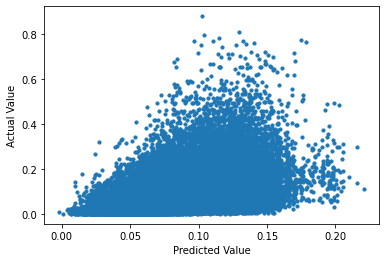

In [18]:
plt.scatter(y_pred, y_test, s=10)
plt.xlabel("Predicted Value")
plt.ylabel("Actual Value")
plt.show()

## 2. MLP 사용

In [12]:
#dataset 설정
class Missing_Value_Dataset(Dataset):
    
    def __init__(self,df):
        self.df = df
        
        self.x = df.iloc[:,1:].to_numpy()
        self.y = df['PM2.5'].to_numpy()
        
        self.x = torch.tensor(self.x, dtype=torch.float)
        self.y = torch.tensor(self.y, dtype=torch.float)
        
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
                          
    
    def __len__(self):
        return len(self.y)

data_dict = {}    
train_path = '/opt/ml/data/TRAIN'
trainaws_path = '/opt/ml/data/TRAIN_AWS/'

def merge_df(pm_loca, aws_loca):
    df_pm_loca = pd.read_csv(os.path.join(train_path, pm_loca+'.csv'))
    df_aws_loca = pd.read_csv(os.path.join(trainaws_path, aws_loca+'.csv')).iloc[:,3:]
    df = pd.concat([df_pm_loca,df_aws_loca],axis=1).iloc[:,3:].dropna(how='any')
    return df
    
    

for loca in aws_match_list:
    pm_loca, aws_loca = loca
    data_dict[pm_loca] = merge_df(pm_loca, aws_loca)    

df_total = pd.concat(list(data_dict.values()),axis=0)   
batch_size = 256
dataset = Missing_Value_Dataset(df_total)

n_val = 20000
n_train = len(dataset) - n_val
train_set, val_set = random_split(dataset, [n_train, n_val])

In [13]:
# 모델 설정
class UPBlock(nn.Module):
    def __init__(self, in_dims):
        super().__init__()
        self.in_dims = in_dims
        
        self.upblock = nn.Sequential(
                      nn.Linear(self.in_dims, self.in_dims*2),
                      nn.BatchNorm1d(self.in_dims*2),
                      nn.Dropout(p=0.1),
                      nn.ReLU()
        )
        
    def forward(self,x):
        return self.upblock(x)

    
class DownBlock(nn.Module):
    def __init__(self, in_dims):
        super().__init__()
        self.in_dims = in_dims
        
        self.downblock = nn.Sequential(
                      nn.Linear(self.in_dims, self.in_dims//2),
                      nn.BatchNorm1d(self.in_dims//2),
                      nn.Dropout(p=0.1),
                      nn.ReLU()
        )
        
    def forward(self,x):
        return self.downblock(x)

    
class MLPModel(nn.Module):
    def __init__(self, in_dims, out_dims):
        super().__init__()
        self.in_dims = in_dims
        self.out_dims = out_dims
        
        self.upblock1 = UPBlock(self.in_dims)
        self.upblock2 = UPBlock(self.in_dims*2)
        self.upblock3 = UPBlock(self.in_dims*4)
        self.upblock4 = UPBlock(self.in_dims*8)
        self.upblock5 = UPBlock(self.in_dims*16)
        
        self.downblock1 = DownBlock(self.in_dims*32)
        self.downblock2 = DownBlock(self.in_dims*16)
        self.downblock3 = DownBlock(self.in_dims*8)
        self.downblock4 = DownBlock(self.in_dims*4)
        self.downblock5 = DownBlock(self.in_dims*2)
        
        self.fc = nn.Linear(self.in_dims, self.out_dims)
        
        self.apply(self.initialize_weights)
        
    def forward(self,x):
        out = self.upblock1(x)
        out = self.upblock2(out)
        out = self.upblock3(out)
        out = self.upblock4(out)
        out = self.upblock5(out)
        
        out = self.downblock1(out)
        out = self.downblock2(out)
        out = self.downblock3(out)
        out = self.downblock4(out)
        out = self.downblock5(out)
        
        out = self.fc(out)
        
        return out
    
    def initialize_weights(self, module):        
        for m in module.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                m.bias.data.zero_()

In [14]:
train_loader = DataLoader(train_set, shuffle=True, batch_size=batch_size, num_workers=4)
val_loader = DataLoader(val_set, shuffle=False, batch_size=batch_size, num_workers=4)

In [15]:
# Hyperparameters
# lr = 0.00001
device = 'cuda'
# epochs = 30
model = MLPModel(5,1).to(device, non_blocking=True)
# criterion =nn.MSELoss()
# optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.7)
# model_name = 'MLP_결측치예측모델'

In [ ]:
#미리 학습한 가중치 사용
model.load_state_dict(torch.load('/opt/ml/parameter/MLP_결측치예측모델/Epoch:6-loss:0.005269-mae:12.783139%-best.pt'))

In [18]:
all_predictions = []
for data,y in tqdm(val_loader, leave=False):
    with torch.no_grad():
        data = data.to(device)
        pred = model(data)
        pred = torch.flatten(pred)
    all_predictions.extend(pred.detach().cpu().numpy())
    
predict = np.array(all_predictions)
predict = np.where(predict<0, 0.0, predict)

real = []
for data,y in tqdm(val_loader, leave=False):
    real.extend(y.detach().cpu().numpy())
real = np.array(real)
print('explained_variance_score: {}'.format(explained_variance_score(real, predict)))
print('mean_squared_errors: {}'.format(mean_squared_error(real, predict)))
print('r2_score: {}'.format(r2_score(real, predict)))

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

explained_variance_score: -0.4165581464767456
mean_squared_errors: 0.007486846297979355
r2_score: -0.41658428948429704


* 만든 MLP보다 XGBoost 성능이 더 좋은 관계로 PM 결측치 대치에는 XGBoost 사용

## 3. 결측치 채우기

In [19]:
data_dict = {}    
train_path = '/opt/ml/data/TRAIN'
trainaws_path = '/opt/ml/data/TRAIN_AWS/'

def merge_df(pm_loca, aws_loca):
    df_pm_loca = pd.read_csv(os.path.join(train_path, pm_loca+'.csv'))
    df_aws_loca = pd.read_csv(os.path.join(trainaws_path, aws_loca+'.csv')).iloc[:,3:]
    df = pd.concat([df_pm_loca,df_aws_loca],axis=1).iloc[:,3:]
    return df
    
    

for loca in aws_match_list:
    pm_loca, aws_loca = loca
    data_dict[pm_loca] = merge_df(pm_loca, aws_loca)

### PM 결측치 -> XGBoost사용

In [21]:
#17개 지역 data 합치기
df_total = pd.concat(list(data_dict.values()),axis=0)
df_total = df_total.reset_index(drop=True)#index 다시설정

#pm결측지 데이터
miss_data = df_total[(df_total['PM2.5'].isna().values)].iloc[:,1:].to_numpy()
miss_idx = df_total['PM2.5'].index[df_total['PM2.5'].isna()]

#input 데이터 설정
dinput = xgb.DMatrix(data=miss_data)

#결측지 예측
y_pred = xgb_model.predict(dinput)

#결측지 imputation
for pred, idx in zip(y_pred, miss_idx):
     df_total['PM2.5'].iloc[idx] = pred

#음수 -> 0 
df_total['PM2.5'] = np.where(df_total['PM2.5'] < 0, abs(df_total['PM2.5']), df_total['PM2.5'])
df_total['PM2.5'].min()

0.0

### aws 결측치 -> MICE사용

In [24]:
#MICE-> aws 예측
from fancyimpute import IterativeImputer

imputer = IterativeImputer(random_state=42)
imput_data = imputer.fit_transform(df_total)

#음수 -> 0 
imput_data = np.where(imput_data < 0, abs(imput_data), imput_data)
df_final = pd.DataFrame(imput_data)
df_final.describe()

,0,1,2,3,4,5
count,596088.000000,596088.000000,596088.000000,596088.000000,596088.000000,596088.000000
mean,0.084930,0.581957,0.418071,0.040317,0.001551,0.706082
std,0.070926,0.164181,0.339241,0.035492,0.012228,0.204537
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.040000,0.451817,0.042222,0.012788,0.000000,0.562000
50%,0.068000,0.592417,0.418240,0.033248,0.000000,0.723000
75%,0.110328,0.717220,0.722778,0.056266,0.000000,0.887000
max,1.000000,0.998420,1.000000,0.434783,0.897727,0.988000


* 결측치 대치 전 분포와 비슷한 분포를 보임

In [25]:
#결측치 존재 여부 체크
df_final.isna().sum()

0    0
1    0
2    0
3    0
4    0
5    0
dtype: int64

In [ ]:
#아름동, 신흥동, 노은동 지역 PM값 이상치 제거 확인
fig, axes = plt.subplots(nrows=3, ncols=1, figsize = (8,12))
sns.lineplot(df_final[:35064][0], ax=axes[0])
sns.lineplot(df_final[35064:35064*2][0], ax=axes[1])
sns.lineplot(df_final[35064*2:35064*3][0], ax=axes[2])

In [ ]:
#아름동, 신흥동, 노은동 지역 풍속 이상치 제거 확인
fig, axes = plt.subplots(nrows=3, ncols=1, figsize = (8,12))
sns.lineplot(df_final[:35064][3], ax=axes[0])
sns.lineplot(df_final[35064:35064*2][3], ax=axes[1])
sns.lineplot(df_final[35064*2:35064*3][3], ax=axes[2])

# Train

## Dataset

In [27]:
class dataset48(Dataset):
    
    def __init__(self,df):
        self.df = df
        self.data = df.to_numpy()
        
        self.input = []
        self.out = []
        
        #통합데이터를 17개 지역 수로 나눔
        loca_data_num = len(self.data)//17
        
        #데이터를 17개 지역으로 분리해서 각 지역에 해당하는 input과 label만을 매칭함
        for loca in range(17):
                
            loca_idx = loca*loca_data_num
            
            for i in range(loca_idx, loca_idx+loca_data_num-120):                    
                self.input.append(self.data[i:i+48])#2일 치 정보
                self.out.append(self.data[i+48:i+120,0])#3일 치 pm 값
        
        self.input = torch.tensor(self.input, dtype=torch.float)
        self.out = torch.tensor(self.out, dtype=torch.float)
        
    def __getitem__(self, idx):
        return self.input[idx], self.out[idx]
                          
    
    def __len__(self):
        return len(self.out)  

In [28]:
batch_size = 256
dataset = dataset48(df_final)

n_val = 20000
n_train = len(dataset) - n_val
train_set, val_set = random_split(dataset, [n_train, n_val])

In [29]:
train_loader = DataLoader(train_set, shuffle=True, batch_size=batch_size, num_workers=4)
val_loader = DataLoader(val_set, shuffle=True, batch_size=batch_size, num_workers=4)

# Model

In [30]:
class TFModel(nn.Module):
    def __init__(self, d_model, nhead, h_dim, nlayers, dropout=0.3):
        super(TFModel, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(5, d_model//2),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(d_model//2, d_model)
        )

        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=h_dim, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=nlayers) 
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        
        self.linear1 =  nn.Sequential(
            nn.Linear(d_model, d_model//2),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(d_model//2, 1)
        )
        
        self.linear2 = nn.Sequential(
            nn.Linear(48,48),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(48,72)
        )

    def forward(self, src):
        src = self.encoder(src)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        output = self.linear1(output)[:,:,0]
        output = self.linear2(output)
        return output

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self,input_size=6, hidden_size=64, num_layers=2, dropout=0.3):
        super().__init__()
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers,  dropout= dropout)
        self.linear1 = nn.Sequential(
            nn.Linear(in_features=hidden_size, out_features=6),
            nn.ReLU(),
            nn.Linear(in_features=6, out_features=1))
        self.linear2 = nn.Linear(in_features=48, out_features=72)
        
        self.apply(self.initialize_weights)
        
    def forward(self, x, hidden, cell):
        out, _ = self.lstm(x,(hidden,cell))
        out = F.relu(out)
        out = F.dropout(out, p=0.1)
        out = self.linear1(out)
        out = F.relu(out)
        out = out.squeeze()
        out = F.dropout(out, p=0.3)
        out = self.linear2(out)
        return out
    
    def initialize_weights(self, module):        
        for m in module.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                m.bias.data.zero_()

* 실험 결과 Transformer가 성능이 더 좋음
* Transformer는 Encoder 부분만을 사용함
* Model로 Transformer 사용

In [44]:
# Hyperparameters
lr = 0.00001
device = 'cuda'
epochs = 50
# model = LSTMModel(6 ,64,6).to(device, non_blocking=True)
model = TFModel(512, 8, 1024, 15).to(device, non_blocking=True)
criterion =nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.7)
model_name = 'TransformerEncoder_10차실험_결측치대치_mseloss_절대값_12'

In [46]:
wandb.init(
project=f'PM_Prediction',
    name = f'{model_name}',
    config={
        "architecture": model_name,
        "batch_size" : batch_size
        })

#AMP 사용
scaler = torch.cuda.amp.GradScaler()
best_val_mae = np.inf
best_val_loss = np.inf

for epoch in tqdm(range(epochs),leave=False):
    print(f'\n Epoch:{epoch+1}'+'#'*30)
    model.train()
    train_loss = 0
    train_mae = 0
#     hidden = torch.zeros(6, 48, 64, requires_grad=True).to(device, non_blocking=True)
#     cell = torch.zeros(6, 48, 64, requires_grad=True).to(device, non_blocking=True)
    for b_idx, (scr, y) in tqdm(enumerate(train_loader),leave=False, total=len(train_loader), ascii=True):
            
        #loss계산
        scr, y = scr.to(device, non_blocking=True), y.to(device, non_blocking=True)
        with torch.autocast(device_type='cuda', dtype=torch.float16):
            result = model(scr)
            loss = criterion(result, y)
           
        optimizer.zero_grad(set_to_none=True)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        train_loss += loss
        train_mae += torch.abs((result - y)).sum().item()
        
        if (b_idx+1)%(len(train_loader)//10) == 0:
            print('Train_loss:{:.6f} \t Train_MAE: {:.6f}'.format(train_loss/(b_idx+1), train_mae/((b_idx+1)*batch_size)))
              
    train_loss /= len(train_loader)
    train_mae /= len(train_loader.dataset)
    train_metrics={"train/train_loss": train_loss, "train/train_MAE": train_mae}
    print('Epoch:{} \t 최종-Train_loss:{:.6f} \t 최종-Train_MAE:{:.6f}'.format(epoch+1, train_loss, train_mae))
        
    scheduler.step()
        
    #validation
    if (epoch+1)%1 == 0:
        with torch.no_grad():
            model.eval()
            val_loss = 0
            val_mae = 0
            for b_idx, (scr, y) in tqdm(enumerate(val_loader),leave=False, total=len(val_loader), ascii=True):
                
                scr, y = scr.to(device, non_blocking=True), y.to(device, non_blocking=True)
                result = model(scr)
                loss = criterion(result, y)
        
                val_loss += loss
                val_mae += torch.abs((result - y)).sum().item()
                
            val_loss /= len(val_loader)
            val_mae /= len(val_loader.dataset)
            print('Epoch:{} \t Val_loss:{:.6f} \t Val_mae:{:.6f}'.format(epoch+1 ,val_loss, val_mae))
            best_val_loss = min(best_val_loss, val_loss)
            if val_mae < best_val_mae:
                print(f"New best model for val MAE : {val_mae:.6}! saving the best model..")
                save_dir = os.path.join('/opt/ml/parameter', model_name) 
                os.makedirs(save_dir, exist_ok=True)
                torch.save(model.state_dict(), 
                       os.path.join(save_dir,f'Epoch:{epoch+1}-loss:{val_loss:.6f}-mae:{val_mae:.6f}%-best2.pt'))
                best_val_mae = val_mae
                
            val_metrics = {"val/val_loss": val_loss, "val/val_mae": val_mae}
            wandb.log({**train_metrics, **val_metrics}, step=epoch)
      
wandb.finish()



 Epoch:1##############################


Train_loss:0.019042 	 Train_MAE: 7.734874
Train_loss:0.018190 	 Train_MAE: 7.535947
Train_loss:0.017173 	 Train_MAE: 7.263925
Train_loss:0.015727 	 Train_MAE: 6.857507
Train_loss:0.014446 	 Train_MAE: 6.491438
Train_loss:0.013423 	 Train_MAE: 6.197019
Train_loss:0.012588 	 Train_MAE: 5.957500
Train_loss:0.011904 	 Train_MAE: 5.759065
Train_loss:0.011318 	 Train_MAE: 5.589128
Train_loss:0.010820 	 Train_MAE: 5.443945
Epoch:1 	 최종-Train_loss:0.010813 	 최종-Train_MAE:5.442351


Epoch:1 	 Val_loss:0.005217 	 Val_mae:3.656313
New best model for val MAE : 3.65631! saving the best model..

 Epoch:2##############################


Train_loss:0.006003 	 Train_MAE: 4.028146
Train_loss:0.005977 	 Train_MAE: 4.010942
Train_loss:0.005907 	 Train_MAE: 3.982982
Train_loss:0.005859 	 Train_MAE: 3.961573
Train_loss:0.005789 	 Train_MAE: 3.936861
Train_loss:0.005732 	 Train_MAE: 3.915442
Train_loss:0.005675 	 Train_MAE: 3.894637
Train_loss:0.005634 	 Train_MAE: 3.877290
Train_loss:0.005585 	 Train_MAE: 3.859008
Train_loss:0.005543 	 Train_MAE: 3.841837
Epoch:2 	 최종-Train_loss:0.005542 	 최종-Train_MAE:3.841592


Epoch:2 	 Val_loss:0.004556 	 Val_mae:3.387347
New best model for val MAE : 3.38735! saving the best model..

 Epoch:3##############################


Train_loss:0.005128 	 Train_MAE: 3.671163
Train_loss:0.005067 	 Train_MAE: 3.654497
Train_loss:0.005020 	 Train_MAE: 3.638182
Train_loss:0.005002 	 Train_MAE: 3.628384
Train_loss:0.004978 	 Train_MAE: 3.617829
Train_loss:0.004952 	 Train_MAE: 3.607203
Train_loss:0.004925 	 Train_MAE: 3.596378
Train_loss:0.004900 	 Train_MAE: 3.586648
Train_loss:0.004876 	 Train_MAE: 3.576861
Train_loss:0.004852 	 Train_MAE: 3.567043
Epoch:3 	 최종-Train_loss:0.004852 	 최종-Train_MAE:3.567060


Epoch:3 	 Val_loss:0.004495 	 Val_mae:3.362693
New best model for val MAE : 3.36269! saving the best model..

 Epoch:4##############################


Train_loss:0.004624 	 Train_MAE: 3.471069
Train_loss:0.004624 	 Train_MAE: 3.467572
Train_loss:0.004622 	 Train_MAE: 3.462209
Train_loss:0.004604 	 Train_MAE: 3.457816
Train_loss:0.004597 	 Train_MAE: 3.453648
Train_loss:0.004569 	 Train_MAE: 3.444657
Train_loss:0.004559 	 Train_MAE: 3.439258
Train_loss:0.004543 	 Train_MAE: 3.433078
Train_loss:0.004532 	 Train_MAE: 3.428526
Train_loss:0.004521 	 Train_MAE: 3.423208
Epoch:4 	 최종-Train_loss:0.004521 	 최종-Train_MAE:3.423161


Epoch:4 	 Val_loss:0.004313 	 Val_mae:3.275257
New best model for val MAE : 3.27526! saving the best model..

 Epoch:5##############################


Train_loss:0.004397 	 Train_MAE: 3.371963
Train_loss:0.004390 	 Train_MAE: 3.365761
Train_loss:0.004394 	 Train_MAE: 3.364921
Train_loss:0.004384 	 Train_MAE: 3.361040
Train_loss:0.004390 	 Train_MAE: 3.362057
Train_loss:0.004375 	 Train_MAE: 3.356645
Train_loss:0.004365 	 Train_MAE: 3.351863
Train_loss:0.004355 	 Train_MAE: 3.347187
Train_loss:0.004343 	 Train_MAE: 3.342882
Train_loss:0.004335 	 Train_MAE: 3.339159
Epoch:5 	 최종-Train_loss:0.004335 	 최종-Train_MAE:3.339192


Epoch:5 	 Val_loss:0.004168 	 Val_mae:3.198263
New best model for val MAE : 3.19826! saving the best model..

 Epoch:6##############################


Train_loss:0.004269 	 Train_MAE: 3.310514
Train_loss:0.004278 	 Train_MAE: 3.308681
Train_loss:0.004262 	 Train_MAE: 3.302616
Train_loss:0.004263 	 Train_MAE: 3.301707
Train_loss:0.004241 	 Train_MAE: 3.295017
Train_loss:0.004237 	 Train_MAE: 3.292190
Train_loss:0.004228 	 Train_MAE: 3.288857
Train_loss:0.004218 	 Train_MAE: 3.285569
Train_loss:0.004214 	 Train_MAE: 3.284772
Train_loss:0.004209 	 Train_MAE: 3.282315
Epoch:6 	 최종-Train_loss:0.004209 	 최종-Train_MAE:3.282326


Epoch:6 	 Val_loss:0.004127 	 Val_mae:3.179580
New best model for val MAE : 3.17958! saving the best model..

 Epoch:7##############################


Train_loss:0.004138 	 Train_MAE: 3.253837
Train_loss:0.004145 	 Train_MAE: 3.253676
Train_loss:0.004152 	 Train_MAE: 3.254480
Train_loss:0.004151 	 Train_MAE: 3.255953
Train_loss:0.004150 	 Train_MAE: 3.254237
Train_loss:0.004147 	 Train_MAE: 3.252858
Train_loss:0.004146 	 Train_MAE: 3.252838
Train_loss:0.004145 	 Train_MAE: 3.252675
Train_loss:0.004137 	 Train_MAE: 3.249551
Train_loss:0.004135 	 Train_MAE: 3.249360
Epoch:7 	 최종-Train_loss:0.004136 	 최종-Train_MAE:3.249482


Epoch:7 	 Val_loss:0.004056 	 Val_mae:3.148180
New best model for val MAE : 3.14818! saving the best model..

 Epoch:8##############################


Train_loss:0.004127 	 Train_MAE: 3.241261
Train_loss:0.004109 	 Train_MAE: 3.236979
Train_loss:0.004128 	 Train_MAE: 3.241712
Train_loss:0.004116 	 Train_MAE: 3.237157
Train_loss:0.004119 	 Train_MAE: 3.238213
Train_loss:0.004116 	 Train_MAE: 3.238170
Train_loss:0.004116 	 Train_MAE: 3.238532
Train_loss:0.004110 	 Train_MAE: 3.236940
Train_loss:0.004101 	 Train_MAE: 3.233627
Train_loss:0.004096 	 Train_MAE: 3.232446
Epoch:8 	 최종-Train_loss:0.004096 	 최종-Train_MAE:3.232592


Epoch:8 	 Val_loss:0.003946 	 Val_mae:3.157391

 Epoch:9##############################


Train_loss:0.004103 	 Train_MAE: 3.233811
Train_loss:0.004113 	 Train_MAE: 3.233685
Train_loss:0.004110 	 Train_MAE: 3.236187
Train_loss:0.004090 	 Train_MAE: 3.230793
Train_loss:0.004077 	 Train_MAE: 3.227016
Train_loss:0.004073 	 Train_MAE: 3.225623
Train_loss:0.004071 	 Train_MAE: 3.224196
Train_loss:0.004072 	 Train_MAE: 3.223464
Train_loss:0.004070 	 Train_MAE: 3.221674
Train_loss:0.004068 	 Train_MAE: 3.221316
Epoch:9 	 최종-Train_loss:0.004068 	 최종-Train_MAE:3.221149


Epoch:9 	 Val_loss:0.004035 	 Val_mae:3.138867
New best model for val MAE : 3.13887! saving the best model..

 Epoch:10##############################


Train_loss:0.004075 	 Train_MAE: 3.225962
Train_loss:0.004052 	 Train_MAE: 3.218741
Train_loss:0.004039 	 Train_MAE: 3.210804
Train_loss:0.004045 	 Train_MAE: 3.212660
Train_loss:0.004053 	 Train_MAE: 3.215310
Train_loss:0.004051 	 Train_MAE: 3.214306
Train_loss:0.004055 	 Train_MAE: 3.214885
Train_loss:0.004053 	 Train_MAE: 3.214840
Train_loss:0.004047 	 Train_MAE: 3.213227
Train_loss:0.004044 	 Train_MAE: 3.212562
Epoch:10 	 최종-Train_loss:0.004044 	 최종-Train_MAE:3.212434


Epoch:10 	 Val_loss:0.003961 	 Val_mae:3.133502
New best model for val MAE : 3.1335! saving the best model..

 Epoch:11##############################


Train_loss:0.004074 	 Train_MAE: 3.222959
Train_loss:0.004063 	 Train_MAE: 3.219095
Train_loss:0.004058 	 Train_MAE: 3.219800
Train_loss:0.004052 	 Train_MAE: 3.215438
Train_loss:0.004039 	 Train_MAE: 3.210976
Train_loss:0.004038 	 Train_MAE: 3.210669
Train_loss:0.004037 	 Train_MAE: 3.209559
Train_loss:0.004029 	 Train_MAE: 3.206418
Train_loss:0.004035 	 Train_MAE: 3.208209
Train_loss:0.004029 	 Train_MAE: 3.206961
Epoch:11 	 최종-Train_loss:0.004029 	 최종-Train_MAE:3.206905


Epoch:11 	 Val_loss:0.003989 	 Val_mae:3.145049

 Epoch:12##############################


Train_loss:0.004021 	 Train_MAE: 3.197367
Train_loss:0.004020 	 Train_MAE: 3.202090
Train_loss:0.004025 	 Train_MAE: 3.201782
Train_loss:0.004013 	 Train_MAE: 3.199597
Train_loss:0.004021 	 Train_MAE: 3.203359
Train_loss:0.004028 	 Train_MAE: 3.205170
Train_loss:0.004027 	 Train_MAE: 3.204357
Train_loss:0.004024 	 Train_MAE: 3.203450
Train_loss:0.004019 	 Train_MAE: 3.201691
Train_loss:0.004016 	 Train_MAE: 3.201408
Epoch:12 	 최종-Train_loss:0.004016 	 최종-Train_MAE:3.201365


Epoch:12 	 Val_loss:0.003926 	 Val_mae:3.123576
New best model for val MAE : 3.12358! saving the best model..

 Epoch:13##############################


Train_loss:0.003978 	 Train_MAE: 3.189732
Train_loss:0.004006 	 Train_MAE: 3.193169
Train_loss:0.004001 	 Train_MAE: 3.193984
Train_loss:0.004000 	 Train_MAE: 3.196055
Train_loss:0.004002 	 Train_MAE: 3.196138
Train_loss:0.004007 	 Train_MAE: 3.197707
Train_loss:0.004011 	 Train_MAE: 3.198311
Train_loss:0.004011 	 Train_MAE: 3.198769
Train_loss:0.004008 	 Train_MAE: 3.197422
Train_loss:0.004002 	 Train_MAE: 3.195738
Epoch:13 	 최종-Train_loss:0.004002 	 최종-Train_MAE:3.195663


Epoch:13 	 Val_loss:0.003910 	 Val_mae:3.131457

 Epoch:14##############################


Train_loss:0.004009 	 Train_MAE: 3.194563
Train_loss:0.003996 	 Train_MAE: 3.191329
Train_loss:0.003982 	 Train_MAE: 3.189949
Train_loss:0.003981 	 Train_MAE: 3.189399
Train_loss:0.003997 	 Train_MAE: 3.194285
Train_loss:0.003994 	 Train_MAE: 3.193563
Train_loss:0.003992 	 Train_MAE: 3.192039
Train_loss:0.003991 	 Train_MAE: 3.191463
Train_loss:0.003997 	 Train_MAE: 3.193233
Train_loss:0.003997 	 Train_MAE: 3.193272
Epoch:14 	 최종-Train_loss:0.003997 	 최종-Train_MAE:3.193272


Epoch:14 	 Val_loss:0.003916 	 Val_mae:3.123431
New best model for val MAE : 3.12343! saving the best model..

 Epoch:15##############################


Train_loss:0.004041 	 Train_MAE: 3.201097
Train_loss:0.004008 	 Train_MAE: 3.194140
Train_loss:0.003979 	 Train_MAE: 3.185727
Train_loss:0.003989 	 Train_MAE: 3.188015
Train_loss:0.003990 	 Train_MAE: 3.189506
Train_loss:0.003996 	 Train_MAE: 3.192876
Train_loss:0.003990 	 Train_MAE: 3.191225
Train_loss:0.003993 	 Train_MAE: 3.191750
Train_loss:0.003992 	 Train_MAE: 3.191228
Train_loss:0.003990 	 Train_MAE: 3.189806
Epoch:15 	 최종-Train_loss:0.003990 	 최종-Train_MAE:3.189915


Epoch:15 	 Val_loss:0.003931 	 Val_mae:3.135113

 Epoch:16##############################


Train_loss:0.004032 	 Train_MAE: 3.202278
Train_loss:0.004008 	 Train_MAE: 3.193927
Train_loss:0.004005 	 Train_MAE: 3.190474
Train_loss:0.003993 	 Train_MAE: 3.187624
Train_loss:0.003990 	 Train_MAE: 3.187886
Train_loss:0.003988 	 Train_MAE: 3.187715
Train_loss:0.003990 	 Train_MAE: 3.189227
Train_loss:0.003988 	 Train_MAE: 3.188312
Train_loss:0.003987 	 Train_MAE: 3.188095
Train_loss:0.003980 	 Train_MAE: 3.186250
Epoch:16 	 최종-Train_loss:0.003980 	 최종-Train_MAE:3.186250


Epoch:16 	 Val_loss:0.003922 	 Val_mae:3.118424
New best model for val MAE : 3.11842! saving the best model..

 Epoch:17##############################


Train_loss:0.004000 	 Train_MAE: 3.192745
Train_loss:0.004028 	 Train_MAE: 3.198216
Train_loss:0.004003 	 Train_MAE: 3.191769
Train_loss:0.003993 	 Train_MAE: 3.188090
Train_loss:0.003983 	 Train_MAE: 3.185349
Train_loss:0.003975 	 Train_MAE: 3.183035
Train_loss:0.003974 	 Train_MAE: 3.183205
Train_loss:0.003979 	 Train_MAE: 3.185202
Train_loss:0.003978 	 Train_MAE: 3.185055
Train_loss:0.003977 	 Train_MAE: 3.184323
Epoch:17 	 최종-Train_loss:0.003978 	 최종-Train_MAE:3.184325


Epoch:17 	 Val_loss:0.003891 	 Val_mae:3.132806

 Epoch:18##############################


Train_loss:0.003968 	 Train_MAE: 3.180465
Train_loss:0.003998 	 Train_MAE: 3.188225
Train_loss:0.003995 	 Train_MAE: 3.188442
Train_loss:0.003994 	 Train_MAE: 3.189702
Train_loss:0.003985 	 Train_MAE: 3.186901
Train_loss:0.003988 	 Train_MAE: 3.186559
Train_loss:0.003988 	 Train_MAE: 3.186613
Train_loss:0.003982 	 Train_MAE: 3.184964
Train_loss:0.003975 	 Train_MAE: 3.183628
Train_loss:0.003975 	 Train_MAE: 3.183335
Epoch:18 	 최종-Train_loss:0.003974 	 최종-Train_MAE:3.183199


Epoch:18 	 Val_loss:0.003916 	 Val_mae:3.121983

 Epoch:19##############################


Train_loss:0.004008 	 Train_MAE: 3.183758
Train_loss:0.004000 	 Train_MAE: 3.184466
Train_loss:0.003974 	 Train_MAE: 3.177835
Train_loss:0.003982 	 Train_MAE: 3.181042
Train_loss:0.003979 	 Train_MAE: 3.181232
Train_loss:0.003973 	 Train_MAE: 3.180191
Train_loss:0.003970 	 Train_MAE: 3.179073
Train_loss:0.003969 	 Train_MAE: 3.179211
Train_loss:0.003972 	 Train_MAE: 3.181271
Train_loss:0.003970 	 Train_MAE: 3.181336
Epoch:19 	 최종-Train_loss:0.003970 	 최종-Train_MAE:3.181232


Epoch:19 	 Val_loss:0.003906 	 Val_mae:3.115513
New best model for val MAE : 3.11551! saving the best model..

 Epoch:20##############################


Train_loss:0.004015 	 Train_MAE: 3.189432
Train_loss:0.003990 	 Train_MAE: 3.183459
Train_loss:0.003991 	 Train_MAE: 3.184056
Train_loss:0.003986 	 Train_MAE: 3.182023
Train_loss:0.003979 	 Train_MAE: 3.181263
Train_loss:0.003964 	 Train_MAE: 3.177988
Train_loss:0.003962 	 Train_MAE: 3.177429
Train_loss:0.003966 	 Train_MAE: 3.179510
Train_loss:0.003966 	 Train_MAE: 3.179716
Train_loss:0.003964 	 Train_MAE: 3.179618
Epoch:20 	 최종-Train_loss:0.003964 	 최종-Train_MAE:3.179534


Epoch:20 	 Val_loss:0.003898 	 Val_mae:3.111243
New best model for val MAE : 3.11124! saving the best model..

 Epoch:21##############################


Train_loss:0.003925 	 Train_MAE: 3.171030
Train_loss:0.003940 	 Train_MAE: 3.173041
Train_loss:0.003936 	 Train_MAE: 3.170674
Train_loss:0.003946 	 Train_MAE: 3.175629
Train_loss:0.003952 	 Train_MAE: 3.176978
Train_loss:0.003955 	 Train_MAE: 3.177553
Train_loss:0.003955 	 Train_MAE: 3.177494
Train_loss:0.003954 	 Train_MAE: 3.177049
Train_loss:0.003959 	 Train_MAE: 3.178559
Train_loss:0.003961 	 Train_MAE: 3.178407
Epoch:21 	 최종-Train_loss:0.003961 	 최종-Train_MAE:3.178431


Epoch:21 	 Val_loss:0.003917 	 Val_mae:3.138616

 Epoch:22##############################


Train_loss:0.003954 	 Train_MAE: 3.182418
Train_loss:0.003951 	 Train_MAE: 3.177381
Train_loss:0.003969 	 Train_MAE: 3.180712
Train_loss:0.003964 	 Train_MAE: 3.178151
Train_loss:0.003966 	 Train_MAE: 3.178576
Train_loss:0.003965 	 Train_MAE: 3.179523
Train_loss:0.003961 	 Train_MAE: 3.177394
Train_loss:0.003962 	 Train_MAE: 3.177175
Train_loss:0.003962 	 Train_MAE: 3.177471
Train_loss:0.003959 	 Train_MAE: 3.177189
Epoch:22 	 최종-Train_loss:0.003960 	 최종-Train_MAE:3.177220


Epoch:22 	 Val_loss:0.003889 	 Val_mae:3.119999

 Epoch:23##############################


Train_loss:0.003960 	 Train_MAE: 3.184578
Train_loss:0.003963 	 Train_MAE: 3.178700
Train_loss:0.003965 	 Train_MAE: 3.178166
Train_loss:0.003958 	 Train_MAE: 3.177489
Train_loss:0.003959 	 Train_MAE: 3.177269
Train_loss:0.003949 	 Train_MAE: 3.174559
Train_loss:0.003952 	 Train_MAE: 3.174886
Train_loss:0.003961 	 Train_MAE: 3.176367
Train_loss:0.003961 	 Train_MAE: 3.176639
Train_loss:0.003956 	 Train_MAE: 3.176238
Epoch:23 	 최종-Train_loss:0.003956 	 최종-Train_MAE:3.176192


Epoch:23 	 Val_loss:0.003923 	 Val_mae:3.125280

 Epoch:24##############################


Train_loss:0.004015 	 Train_MAE: 3.199921
Train_loss:0.003991 	 Train_MAE: 3.192889
Train_loss:0.003992 	 Train_MAE: 3.189827
Train_loss:0.003966 	 Train_MAE: 3.183372
Train_loss:0.003965 	 Train_MAE: 3.181924
Train_loss:0.003968 	 Train_MAE: 3.181204
Train_loss:0.003961 	 Train_MAE: 3.178902
Train_loss:0.003957 	 Train_MAE: 3.176545
Train_loss:0.003957 	 Train_MAE: 3.176349
Train_loss:0.003954 	 Train_MAE: 3.175438
Epoch:24 	 최종-Train_loss:0.003954 	 최종-Train_MAE:3.175399


Epoch:24 	 Val_loss:0.003902 	 Val_mae:3.124763

 Epoch:25##############################


Train_loss:0.003963 	 Train_MAE: 3.176927
Train_loss:0.003966 	 Train_MAE: 3.179096
Train_loss:0.003963 	 Train_MAE: 3.178298
Train_loss:0.003957 	 Train_MAE: 3.174885
Train_loss:0.003956 	 Train_MAE: 3.175838
Train_loss:0.003961 	 Train_MAE: 3.177255
Train_loss:0.003955 	 Train_MAE: 3.175090
Train_loss:0.003953 	 Train_MAE: 3.174775
Train_loss:0.003955 	 Train_MAE: 3.175081
Train_loss:0.003950 	 Train_MAE: 3.174134
Epoch:25 	 최종-Train_loss:0.003950 	 최종-Train_MAE:3.174175


Epoch:25 	 Val_loss:0.003904 	 Val_mae:3.115962

 Epoch:26##############################


Train_loss:0.003881 	 Train_MAE: 3.156444
Train_loss:0.003959 	 Train_MAE: 3.177003
Train_loss:0.003949 	 Train_MAE: 3.174040
Train_loss:0.003955 	 Train_MAE: 3.176720
Train_loss:0.003967 	 Train_MAE: 3.180038
Train_loss:0.003958 	 Train_MAE: 3.176802
Train_loss:0.003963 	 Train_MAE: 3.178390
Train_loss:0.003959 	 Train_MAE: 3.176951
Train_loss:0.003955 	 Train_MAE: 3.175789
Train_loss:0.003951 	 Train_MAE: 3.174159
Epoch:26 	 최종-Train_loss:0.003951 	 최종-Train_MAE:3.174020


Epoch:26 	 Val_loss:0.003890 	 Val_mae:3.117727

 Epoch:27##############################


Train_loss:0.003936 	 Train_MAE: 3.171952
Train_loss:0.003962 	 Train_MAE: 3.181355
Train_loss:0.003961 	 Train_MAE: 3.178996
Train_loss:0.003959 	 Train_MAE: 3.178033
Train_loss:0.003945 	 Train_MAE: 3.173430
Train_loss:0.003943 	 Train_MAE: 3.171411
Train_loss:0.003948 	 Train_MAE: 3.172334
Train_loss:0.003946 	 Train_MAE: 3.172106
Train_loss:0.003950 	 Train_MAE: 3.173086
Train_loss:0.003949 	 Train_MAE: 3.173081
Epoch:27 	 최종-Train_loss:0.003948 	 최종-Train_MAE:3.172968


Epoch:27 	 Val_loss:0.003901 	 Val_mae:3.126323

 Epoch:28##############################


Train_loss:0.003941 	 Train_MAE: 3.173397
Train_loss:0.003924 	 Train_MAE: 3.170096
Train_loss:0.003925 	 Train_MAE: 3.170225


KeyboardInterrupt: 

# Test Dataset

In [47]:
#Test dataset
class TestDataset(Dataset):
    def __init__(self, local_list, aws_match_dict):
        self.local_list = sorted(local_list)
        self.aws_match_dict = aws_match_dict
        
        self.data_list = []
        
        for loca in self.local_list:
            test_pm_path = os.path.join('/opt/ml/data/TEST_INPUT', loca+'.csv')
            test_aws_path = os.path.join('/opt/ml/data/TEST_AWS', aws_match_dict[loca]+'.csv')
            
            df_pm = pd.read_csv(test_pm_path).dropna(how='any').iloc[:-48]
            df_aws = pd.read_csv(test_aws_path).dropna(how='any').iloc[:-48,3:]
            
            df = pd.concat([df_pm, df_aws],axis=1).iloc[:,3:]
            self.data_list.append(df)
        
        self.x = torch.tensor(pd.concat(self.data_list, axis=0).to_numpy(), dtype=torch.float)
        self.x = self.x.reshape((-1,48,6)) 
        
    def __getitem__(self, index):
        return self.x[index]

    def __len__(self):
        return len(self.x)

In [48]:
submission = pd.read_csv('/opt/ml/data/answer_sample.csv')
local_list = sorted(data_dict.keys())
test_set = TestDataset(local_list, aws_match_dict)
loader = DataLoader(test_set, shuffle=False, batch_size=5, num_workers=4)

In [49]:
model.load_state_dict(torch.load('/opt/ml/parameter/TransformerEncoder_10차실험_결측치대치_mseloss_절대값_12/Epoch:20-loss:0.003898-mae:3.111243%-best2.pt'))

<All keys matched successfully>

In [50]:
all_predictions = []
for data in tqdm(loader, leave=False):
    with torch.no_grad():
        data = data.to(device)
        pred = model(data)
        pred = torch.flatten(pred)
    all_predictions.extend(pred.detach().cpu().numpy())

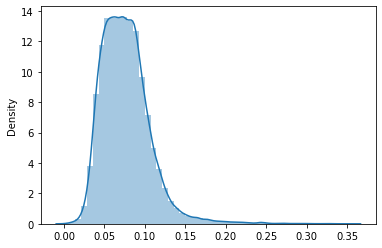

In [51]:
predict = np.array(all_predictions)
predict = np.where(predict<0, abs(predict), predict)
sns.distplot(pd.DataFrame({'ans':predict}))

In [54]:
submission['PM2.5'] = predict
submission.to_csv(os.path.join('/opt/ml/submission_pm', f'{model_name}.csv'), index=False, encoding="utf-8")
print('test inference is done!')

test inference is done!
